In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

训练分类器的步骤：
- 使用torchvision下载cifar10数据集
- 定义卷积神经网络
- 定义损失函数
- 在训练集上训练模型
- 在测试集上测试模型

In [9]:
# torchvision数据集的输出是PILImage格式。 给定均值、方差将Tensor正则化
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


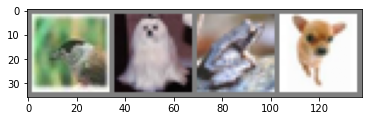

       bird         dog        frog         dog


In [29]:
import matplotlib.pyplot as plt 
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    # 进行维度上的转换(3, 32, 32) -> (32, 32, 3)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 从数据迭代器中读取图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图片
imshow(torchvision.utils.make_grid(images))

# 打印标签
print(' '.join('%11s' % classes[labels[j]] for j in range(4)))

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # 变换x的形状以适配全连接层的输入
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
net = Net()

In [61]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
import torch.optim as optim 

In [62]:
# 交叉熵损失函数，选用随机梯度下降优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [63]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # 打印轮次和损失值
        running_loss += loss.item()
        if (i + 1) % 2000 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.208
[1,  4000] loss: 1.891
[1,  6000] loss: 1.695
[1,  8000] loss: 1.596
[1, 10000] loss: 1.531
[1, 12000] loss: 1.490
[2,  2000] loss: 1.431
[2,  4000] loss: 1.403
[2,  6000] loss: 1.371
[2,  8000] loss: 1.362
[2, 10000] loss: 1.340
[2, 12000] loss: 1.317
Finished Training


In [64]:
# 保存模型
# 设定模型的保存路径
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [41]:
from datetime import datetime
print(datetime.now())

2022-02-02 00:03:25.457473


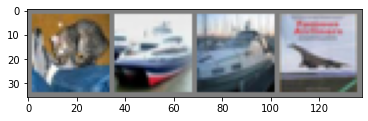

        cat        ship        ship       plane


In [65]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%11s' % classes[labels[j]] for j in range(4)))

In [66]:
# 加载模型
net = Net()
net.load_state_dict(torch.load(PATH))

# 采用模型计算出的概率最大的作为预测的类别
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%11s' % classes[predicted[j]] for j in range(4)))

Predicted:          cat         car       truck        ship


In [67]:
# 在全部测试集上的表现
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Arrucacy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Arrucacy of the network on the 10000 test images: 51 %


In [71]:
# 分类别进行准确率计算
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 59 %
Accuracy of   car: 51 %
Accuracy of  bird: 49 %
Accuracy of   cat: 59 %
Accuracy of  deer: 23 %
Accuracy of   dog: 21 %
Accuracy of  frog: 66 %
Accuracy of horse: 64 %
Accuracy of  ship: 47 %
Accuracy of truck: 69 %


In [73]:
class_correct

[592.0, 518.0, 492.0, 595.0, 234.0, 219.0, 663.0, 648.0, 474.0, 693.0]

In [74]:
class_total

[1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0]

In [77]:
# 在GPU上训练模型
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [78]:
# 将模型转移到GPU上
net.to(device)

inputs, labels = data[0].to(device), data[1].to(device)

In [79]:
net = Net()
net.to(device)

# 交叉熵损失函数，选用随机梯度下降优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # 打印轮次和损失值
        running_loss += loss.item()
        if (i + 1) % 2000 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.211
[1,  4000] loss: 1.837
[1,  6000] loss: 1.672
[1,  8000] loss: 1.563
[1, 10000] loss: 1.503
[1, 12000] loss: 1.457
[2,  2000] loss: 1.388
[2,  4000] loss: 1.362
[2,  6000] loss: 1.352
[2,  8000] loss: 1.331
[2, 10000] loss: 1.289
[2, 12000] loss: 1.284
Finished Training
